## Import the reference

In [2]:
import numpy as np

dt = 0.004

path_to_reference_file = \
    'visualization/optimized_trajectories/path_dense_random_columns_4obj.npy'
    # 'visualization/optimized_trajectories/path_dense_random_columns.npy'
with open( path_to_reference_file, 'rb' ) as f:
    q_ref = np.load(f)      #( N, 4, 4 )
    xi_ref = np.load(f)     #( N, 6, )

Nsim = q_ref.shape[0] - 1
print("Horizon of dataset is", Nsim)

q0 = q_ref[0]       #(4,4)
xi0 = xi_ref[0]     #(6,)
x0 = [ q0, xi0 ]    

Horizon of dataset is 955


## Embedded Euclidean Space Method

In [1]:
import casadi as ca
import numpy as np
from scipy.spatial.transform import Rotation
from manifpy import SE3, SE3Tangent
from traoptlibrary.traopt_utilis import SE32manifSE3

# ================
# 1. 读取参考轨迹
# ================
dt = 0.004

path_to_reference_file = 'visualization/optimized_trajectories/path_dense_random_columns_4obj.npy'
with open(path_to_reference_file, 'rb') as f:
    q_ref = np.load(f)      # shape = (N, 4,4)
    xi_ref = np.load(f)     # shape = (N, 6)
# Nsim = q_ref.shape[0] - 1
Nsim = 50
print("Horizon of dataset is", Nsim)

# 初始状态
# q0 = q_ref[0]       # (4,4) 齐次变换矩阵
# xi0 = xi_ref[0]     # (6,)  含 [omega, v]

# q0 = q_ref[0]
# xi0 = xi_ref[0] 

q0 = SE3.Random().transform()
xi0 = np.ones((6,))

# q0 = Rotation.from_euler('x')

# u0 = np.array([1.,2.,3.,4.,5.,6.])
u0 = np.zeros(6,)

threshold = 1e-9

# ================
# 2. 助手函数
# ================

def ad_se3(xi):
    """
    返回 ad_{xi} (6x6)，其中 xi=[omega, v].
    ad_{[ω,v]} = [[ω^∧, 0],
                  [ v^∧, ω^∧]].
    """
    omega = xi[0:3]
    v     = xi[3:6]
    O = ca.skew(omega)
    V = ca.skew(v)
    top = ca.horzcat(O, ca.MX.zeros(3,3))
    bot = ca.horzcat(V, O)
    return ca.vertcat(top, bot)

def adT_se3(xi):
    """
    返回 ad^*_{xi} = (ad_{xi})^T (6x6).
    常在惯性力学方程中出现: ad^*_{xi} (J xi).
    """
    return ad_se3(xi).T

def V_so3(omega):
    """
    辅助积分矩阵 V(omega) = I + (1-cosθ)/θ^2 ω^∧ + (θ - sinθ)/θ^3 (ω^∧)^2,
    其中 θ = ||omega||.
    当 θ 非常小时，用 Taylor 展开近似.
    """
    theta = ca.sqrt(omega[0]**2 + omega[1]**2 + omega[2]**2)
    O = ca.skew(omega)
    I3 = ca.MX.eye(3)

    one_minus_cos_over_t2 = ca.if_else(theta < threshold,
                                       0.5 - theta**2/24.0,
                                       (1 - ca.cos(theta))/(theta**2))
    theta_minus_sin_over_t3 = ca.if_else(theta < threshold,
                                         1/6.0 - theta**2/120.0,
                                         (theta - ca.sin(theta))/(theta**3))
    # Todo: non-smooth?

    return I3 \
        + one_minus_cos_over_t2 * O \
        + theta_minus_sin_over_t3 * (O @ O)

def invV_so3(omega):
    """
    V(omega) 的逆矩阵。通常可用级数或 closed-form 近似。
    这里简单地直接用 casadi 的 inv() 反演,
    如果对大规模或频繁调用有性能顾虑, 可使用解析公式或插值近似.
    """
    return ca.inv(V_so3(omega))

def log_se3(X):
    """
    SE(3) 的对数映射: 返回 6x1 向量 [ω; v].
    完整实现: 
      1) 先从 R= X[0:3,0:3] 得到 omega (SO(3)对数)
      2) 再从 p= X[0:3,3] 得到 v = V(omega)^{-1} * p
    """
    R = X[0:3,0:3]
    p = X[0:3,3]

    # 1) 先做 SO(3) 的对数
    trace_R = R[0,0] + R[1,1] + R[2,2]
    cos_theta = 0.5*(trace_R - 1)
    cos_theta_clamped = ca.fmax(ca.fmin(cos_theta, 1), -1)
    theta = ca.acos(cos_theta_clamped)

    # skew_part = [ R(2,1)-R(1,2), R(0,2)-R(2,0), R(1,0)-R(0,1) ]
    skew_part = ca.vertcat(
        R[2,1] - R[1,2],
        R[0,2] - R[2,0],
        R[1,0] - R[0,1]
    )
    sin_theta = ca.sin(theta)
    factor = ca.if_else(
        ca.fabs(sin_theta) < threshold,
        0.5,  # 退化近似 => ω=0
        theta/(2*sin_theta)
    )
    omega = factor * skew_part  # 3x1

    # 2) 再对平移:  p => v = V(omega)^(-1) * p
    #    V(omega)见 V_so3(omega). 这里需要先算:
    v = invV_so3(omega) @ p
    # v = V_so3(omega) @ p
    # v = p

    return ca.vertcat(omega, v)

def exp_se3(xi, h=1.0):
    """
    SE(3) 上的指数映射, 带步长 h:
      exp_se3(xi, h) = exp( (h * xi)^\wedge ).
    其中 xi=[ω; v], 并用罗德里格斯公式+V(ω) 计算 4x4 齐次变换矩阵.
    """
    # 1) 拆出角速度和线速度, 乘以 h
    omega = xi[0:3]
    v     = xi[3:6]
    h_omega = h * omega
    h_v     = h * v

    # 2) 先算 R_exp = exp(h_omega^∧) by Rodrigues
    theta = ca.sqrt(h_omega[0]**2 + h_omega[1]**2 + h_omega[2]**2)
    Omega = ca.skew(h_omega)
    I3 = ca.MX.eye(3)

    sin_t_over_t = ca.if_else(theta < threshold,
                              1 - theta**2/6.0,
                              ca.sin(theta)/theta)
    one_minus_cos_over_t2 = ca.if_else(theta < threshold,
                                       0.5 - theta**2/24.0,
                                       (1 - ca.cos(theta))/(theta**2))

    R_exp = I3 + sin_t_over_t*Omega + one_minus_cos_over_t2*(Omega @ Omega)

    # 3) 平移部分 p_exp = V(h_omega) * (h_v)
    V_exp = V_so3(h_omega)
    p_exp = V_exp @ h_v

    # 4) 拼回 4x4
    X_exp = ca.vertcat(
        ca.horzcat(R_exp, p_exp),
        ca.horzcat(ca.MX.zeros(1,3), ca.MX.ones(1,1))
    )
    return X_exp

def inv_se3(X):
    """
    给定一个 4x4 的 SE(3) 齐次变换矩阵 X = [[R, p],
                                             [0, 1]],
    直接返回它的逆:  [[R^T, -R^T p],
                     [ 0,       1   ]].
    注意: 如果 X 不是合法的 SE(3) 矩阵（R 非正交、det != 1 等），则此公式不成立。
    """
    R = X[0:3, 0:3]
    p = X[0:3, 3]

    # R^T
    R_T = R.T

    # -R^T pd
    minus_RTp = -ca.mtimes(R_T, p)

    # 拼回 4x4
    X_inv = ca.vertcat(
        ca.horzcat(R_T, minus_RTp),
        ca.horzcat(ca.DM.zeros(1,3), ca.DM.ones(1,1))
    )
    return X_inv

# ================
# 3. 搭建优化问题
# ================

opti = ca.Opti()

# 惯性/刚体参数(仅示例)
m = 1
J_b_np = np.diag([0.5,0.7,0.9, m,m,m])   # 6x6
J_b_inv_np = np.linalg.inv(J_b_np)
J_b = ca.DM(J_b_np)
J_b_inv = ca.DM(J_b_inv_np)

# 权重
Q_X   = np.diag([10.,10.,10., 1.,1.,1.])   # 用于 Log(X_k X_ref^-1) 的惩罚
Q_xi  = np.diag([1.,1.,1., 1.,1.,1.])
Q_XN  = 10*Q_X
Q_xiN = 10*Q_xi
R_u   = 1e-3 * np.eye(6)         # 控制惩罚

# 定义优化变量
X_vars = []
xi_vars= []
u_vars = []
for k in range(Nsim+1):
    # X_k: 4x4
    Xk = opti.variable(4,4)
    X_vars.append(Xk)
    # xi_k: 6x1
    xik = opti.variable(6,1)
    xi_vars.append(xik)
    if k < Nsim:
        # u_k: 6x1
        uk = opti.variable(6,1)
        u_vars.append(uk)

# 设置初值
opti.set_initial( X_vars[0], q0 )
opti.set_initial( xi_vars[0], xi0 )
for k in range(1,Nsim+1):
    # opti.set_initial(X_vars[k], q_ref[k])        # (4,4)
    # opti.set_initial(X_vars[k], SE3.Random().transform()) 

    q_refk_mnf = SE32manifSE3(q_ref[k])
    delta_q = SE3Tangent(np.ones((6,)) * 1e-3)
    opti.set_initial(X_vars[k], q_refk_mnf.rplus(delta_q).transform())   

    opti.set_initial(xi_vars[k], xi_ref[k])      # (6,)
for k in range(Nsim):
    opti.set_initial(u_vars[k], u0)

# 动力学约束 + 初始条件
for k in range(Nsim):
    Xk   = X_vars[k]
    Xk1  = X_vars[k+1]
    xik  = xi_vars[k]
    xik1 = xi_vars[k+1]
    uk   = u_vars[k]

    # (1) X_{k+1} = X_k * exp_se3(xi_k, dt)
    Xk_prop = ca.mtimes(Xk, exp_se3(xik, dt))
    opti.subject_to(Xk1 - Xk_prop == 0)

    # (2) xi_{k+1} = xi_k + J_b^{-1}( ad^*_{xi_k}(J_b xi_k) + u_k ) * dt
    left  = xik1
    right = xik + dt * ca.mtimes(J_b_inv, (adT_se3(xik) @ (J_b @ xik) + uk))
    opti.subject_to(left - right == 0)

# (3) 初始条件
opti.subject_to(X_vars[0] - q0 == 0)
opti.subject_to(xi_vars[0] - xi0 == 0)

# (可选) 给 X_k 加一些刚体约束, 例如 X[3,:] = [0,0,0,1], etc.
# for k in range(Nsim+1):
#     opti.subject_to(X_vars[k][3,0] == 0)
#     opti.subject_to(X_vars[k][3,1] == 0)
#     opti.subject_to(X_vars[k][3,2] == 0)
#     opti.subject_to(X_vars[k][3,3] == 1)

# ================
# 4. 构建目标函数
# ================
cost = 0
for k in range(Nsim):
    Xk  = X_vars[k]
    xik = xi_vars[k]
    uk  = u_vars[k]
    # 参考
    Xref_k  = q_ref[k]      # (4,4)
    xiref_k = xi_ref[k]     # (6, )
    Xref_k_inv = inv_se3(Xref_k)

    # 误差项: Log(X_k X_ref_k^-1)
    X_err = ca.mtimes(Xk, ca.DM(Xref_k_inv))
    log_Xerr = log_se3(X_err)  # 6x1

    xi_diff = xik - ca.DM(xiref_k)

    cost_att = log_Xerr.T @ ca.DM(Q_X)  @ log_Xerr
    cost_xi  = xi_diff.T  @ ca.DM(Q_xi) @ xi_diff
    cost_u   = uk.T       @ ca.DM(R_u)  @ uk
    cost += cost_att + cost_xi + cost_u
    # cost += cost_xi + cost_u

# 末端项
X_N   = X_vars[Nsim]
xi_N  = xi_vars[Nsim]
Xref_N   = q_ref[Nsim]
xiref_N  = xi_ref[Nsim]
Xref_N_inv = inv_se3(Xref_N)

X_errN = ca.mtimes(X_N, ca.DM(Xref_N_inv))
log_XerrN = log_se3(X_errN)
xi_diffN  = xi_N - ca.DM(xiref_N)

cost_attN = log_XerrN.T @ ca.DM(Q_XN) @ log_XerrN
cost_xiN  = xi_diffN.T  @ ca.DM(Q_xiN) @ xi_diffN
cost += cost_attN + cost_xiN
# cost += cost_xiN

opti.minimize(cost)

# ================
# 5. 求解
# ================
p_opts = {"verbose": False}
s_opts = {"max_iter": 1000}
opti.solver('ipopt', p_opts, s_opts)

sol = None
try:
    sol = opti.solve()
except RuntimeError as e:
    print("Solver failed:", e)

# ================
# 6. 取回解
# ================
if sol is not None:
    print("Optimal cost:", sol.value(cost))
    X_sol = []
    xi_sol= []
    u_sol = []
    for k in range(Nsim+1):
        X_sol_k  = sol.value(X_vars[k])
        xi_sol_k = sol.value(xi_vars[k])
        X_sol.append(X_sol_k)
        xi_sol.append(xi_sol_k)
        if k < Nsim:
            u_sol_k = sol.value(u_vars[k])
            u_sol.append(u_sol_k)

    # 这里 X_sol[k] 就是 4x4, xi_sol[k] 就是 6x1, u_sol[k] 就是 6x1
    print("First state:\n", X_sol[0])
    print("First twist:\n", xi_sol[0])
    print("First control:\n", u_sol[0] if len(u_sol)>0 else None)
else:
    print("No solution found.")


Horizon of dataset is 850

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.2.

Number of nonzeros in equality constraint Jacobian...:   185322
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   163299

Total number of variables............................:    23822
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:    18722
To

## Constraint Stabilization Method

In [1]:
import casadi as ca
import numpy as np
from scipy.spatial.transform import Rotation
from manifpy import SE3, SE3Tangent
from traoptlibrary.traopt_utilis import SE32manifSE3


# ================
# 1. 读取参考轨迹
# ================
dt = 0.004

path_to_reference_file = 'visualization/optimized_trajectories/path_dense_random_columns_4obj.npy'
with open(path_to_reference_file, 'rb') as f:
    q_ref = np.load(f)      # shape = (N, 4,4)
    xi_ref = np.load(f)     # shape = (N, 6)
Nsim = q_ref.shape[0] - 1
Nsim = 850
print("Horizon of dataset is", Nsim)

# 初始状态
# q0 = q_ref[0]       # (4,4) 齐次变换矩阵
# xi0 = xi_ref[0]     # (6,)  含 [omega, v]

# q0 = q_ref[0]
# xi0 = xi_ref[0] 

q0 = SE3.Random().transform()
xi0 = np.ones((6,))

# q0 = Rotation.from_euler('x')

# u0 = np.array([1.,2.,3.,4.,5.,6.])
u0 = np.zeros(6,)

threshold = 1e-9

# ================
# 2. 助手函数
# ================

def ad_se3(xi):
    """
    返回 ad_{xi} (6x6)，其中 xi=[omega, v].
    ad_{[ω,v]} = [[ω^∧, 0],
                  [ v^∧, ω^∧]].
    """
    omega = xi[0:3]
    v     = xi[3:6]
    O = ca.skew(omega)
    V = ca.skew(v)
    top = ca.horzcat(O, ca.MX.zeros(3,3))
    bot = ca.horzcat(V, O)
    return ca.vertcat(top, bot)

def adT_se3(xi):
    """
    返回 ad^*_{xi} = (ad_{xi})^T (6x6).
    常在惯性力学方程中出现: ad^*_{xi} (J xi).
    """
    return ad_se3(xi).T

def V_so3(omega):
    """
    辅助积分矩阵 V(omega) = I + (1-cosθ)/θ^2 ω^∧ + (θ - sinθ)/θ^3 (ω^∧)^2,
    其中 θ = ||omega||.
    当 θ 非常小时，用 Taylor 展开近似.
    """
    theta = ca.sqrt(omega[0]**2 + omega[1]**2 + omega[2]**2)
    O = ca.skew(omega)
    I3 = ca.MX.eye(3)

    one_minus_cos_over_t2 = ca.if_else(theta < threshold,
                                       0.5 - theta**2/24.0,
                                       (1 - ca.cos(theta))/(theta**2))
    theta_minus_sin_over_t3 = ca.if_else(theta < threshold,
                                         1/6.0 - theta**2/120.0,
                                         (theta - ca.sin(theta))/(theta**3))
    # Todo: non-smooth?

    return I3 \
        + one_minus_cos_over_t2 * O \
        + theta_minus_sin_over_t3 * (O @ O)

def invV_so3(omega):
    """
    V(omega) 的逆矩阵。通常可用级数或 closed-form 近似。
    这里简单地直接用 casadi 的 inv() 反演,
    如果对大规模或频繁调用有性能顾虑, 可使用解析公式或插值近似.
    """
    return ca.inv(V_so3(omega))

def log_se3(X):
    """
    SE(3) 的对数映射: 返回 6x1 向量 [ω; v].
    完整实现: 
      1) 先从 R= X[0:3,0:3] 得到 omega (SO(3)对数)
      2) 再从 p= X[0:3,3] 得到 v = V(omega)^{-1} * p
    """
    R = X[0:3,0:3]
    p = X[0:3,3]

    # 1) 先做 SO(3) 的对数
    trace_R = R[0,0] + R[1,1] + R[2,2]
    cos_theta = 0.5*(trace_R - 1)
    cos_theta_clamped = ca.fmax(ca.fmin(cos_theta, 1), -1)
    theta = ca.acos(cos_theta_clamped)

    # skew_part = [ R(2,1)-R(1,2), R(0,2)-R(2,0), R(1,0)-R(0,1) ]
    skew_part = ca.vertcat(
        R[2,1] - R[1,2],
        R[0,2] - R[2,0],
        R[1,0] - R[0,1]
    )
    sin_theta = ca.sin(theta)
    factor = ca.if_else(
        ca.fabs(sin_theta) < threshold,
        0.5,  # 退化近似 => ω=0
        theta/(2*sin_theta)
    )
    omega = factor * skew_part  # 3x1

    # 2) 再对平移:  p => v = V(omega)^(-1) * p
    #    V(omega)见 V_so3(omega). 这里需要先算:
    v = invV_so3(omega) @ p
    # v = V_so3(omega) @ p
    # v = p

    return ca.vertcat(omega, v)

def exp_se3(xi, h=1.0):
    """
    SE(3) 上的指数映射, 带步长 h:
      exp_se3(xi, h) = exp( (h * xi)^\wedge ).
    其中 xi=[ω; v], 并用罗德里格斯公式+V(ω) 计算 4x4 齐次变换矩阵.
    """
    # 1) 拆出角速度和线速度, 乘以 h
    omega = xi[0:3]
    v     = xi[3:6]
    h_omega = h * omega
    h_v     = h * v

    # 2) 先算 R_exp = exp(h_omega^∧) by Rodrigues
    theta = ca.sqrt(h_omega[0]**2 + h_omega[1]**2 + h_omega[2]**2)
    Omega = ca.skew(h_omega)
    I3 = ca.MX.eye(3)

    sin_t_over_t = ca.if_else(theta < threshold,
                              1 - theta**2/6.0,
                              ca.sin(theta)/theta)
    one_minus_cos_over_t2 = ca.if_else(theta < threshold,
                                       0.5 - theta**2/24.0,
                                       (1 - ca.cos(theta))/(theta**2))

    R_exp = I3 + sin_t_over_t*Omega + one_minus_cos_over_t2*(Omega @ Omega)

    # 3) 平移部分 p_exp = V(h_omega) * (h_v)
    V_exp = V_so3(h_omega)
    p_exp = V_exp @ h_v

    # 4) 拼回 4x4
    X_exp = ca.vertcat(
        ca.horzcat(R_exp, p_exp),
        ca.horzcat(ca.MX.zeros(1,3), ca.MX.ones(1,1))
    )
    return X_exp

def inv_se3(X):
    """
    给定一个 4x4 的 SE(3) 齐次变换矩阵 X = [[R, p],
                                             [0, 1]],
    直接返回它的逆:  [[R^T, -R^T p],
                     [ 0,       1   ]].
    注意: 如果 X 不是合法的 SE(3) 矩阵（R 非正交、det != 1 等），则此公式不成立。
    """
    R = X[0:3, 0:3]
    p = X[0:3, 3]

    # R^T
    R_T = R.T

    # -R^T pd
    minus_RTp = -ca.mtimes(R_T, p)

    # 拼回 4x4
    X_inv = ca.vertcat(
        ca.horzcat(R_T, minus_RTp),
        ca.horzcat(ca.DM.zeros(1,3), ca.DM.ones(1,1))
    )
    return X_inv

# ================
# 3. 搭建优化问题
# ================

opti = ca.Opti()

# 惯性/刚体参数(仅示例)
m = 1
J_b_np = np.diag([0.5,0.7,0.9, m,m,m])   # 6x6
J_b_inv_np = np.linalg.inv(J_b_np)
J_b = ca.DM(J_b_np)
J_b_inv = ca.DM(J_b_inv_np)

# 权重
Q_X   = np.diag([10.,10.,10., 1.,1.,1.])   # 用于 Log(X_k X_ref^-1) 的惩罚
Q_xi  = np.diag([1.,1.,1., 1.,1.,1.])
Q_XN  = 10*Q_X
Q_xiN = 10*Q_xi
R_u   = 1e-5 * np.eye(6)         # 控制惩罚

# 定义优化变量
X_vars = []
xi_vars= []
u_vars = []
for k in range(Nsim+1):
    # X_k: 4x4
    Xk = opti.variable(4,4)
    X_vars.append(Xk)
    # xi_k: 6x1
    xik = opti.variable(6,1)
    xi_vars.append(xik)
    if k < Nsim:
        # u_k: 6x1
        uk = opti.variable(6,1)
        u_vars.append(uk)

# 设置初值
opti.set_initial( X_vars[0], q0 )
opti.set_initial( xi_vars[0], xi0 )
for k in range(1,Nsim+1):

    q_refk_mnf = SE32manifSE3(q_ref[k])
    delta_q = SE3Tangent(np.ones((6,)) * 1e-3)
    opti.set_initial(X_vars[k], q_refk_mnf.rplus(delta_q).transform())        # (4,4)
    # opti.set_initial(X_vars[k], SE3.Random().transform()) 

    opti.set_initial(xi_vars[k], xi_ref[k])      # (6,)
for k in range(Nsim):
    opti.set_initial(u_vars[k], u0)

# 动力学约束 + 初始条件
for k in range(Nsim):
    Xk   = X_vars[k]
    Xk1  = X_vars[k+1]
    xik  = xi_vars[k]
    xik1 = xi_vars[k+1]
    uk   = u_vars[k]

    # (1) X_{k+1} = X_k * exp_se3(xi_k, dt)
    kappa = 1e0
    Rk = Xk[:3,:3]
    stab_term = kappa/2 * ( ca.inv(ca.mtimes(ca.transpose(Rk), Rk)) - ca.DM.eye(3))
    stab_term = ca.vertcat(
        ca.horzcat( stab_term, ca.DM.zeros((3,1)) ),
        ca.reshape([0,0,0,1], 1, 4)
    )
    Xk_prop = ca.mtimes(Xk, 
                        exp_se3(xik, dt) + stab_term )
    opti.subject_to(Xk1 - Xk_prop == 0)

    # (2) xi_{k+1} = xi_k + J_b^{-1}( ad^*_{xi_k}(J_b xi_k) + u_k ) * dt
    left  = xik1
    right = xik + dt * ca.mtimes(J_b_inv, (adT_se3(xik) @ (J_b @ xik) + uk))
    opti.subject_to(left - right == 0)

# (3) 初始条件
opti.subject_to(X_vars[0] - q0 == 0)
opti.subject_to(xi_vars[0] - xi0 == 0)

# (可选) 给 X_k 加一些刚体约束, 例如 X[3,:] = [0,0,0,1], etc.
# for k in range(Nsim+1):
#     opti.subject_to(X_vars[k][3,0] == 0)
#     opti.subject_to(X_vars[k][3,1] == 0)
#     opti.subject_to(X_vars[k][3,2] == 0)
#     opti.subject_to(X_vars[k][3,3] == 1)

# ================
# 4. 构建目标函数
# ================
cost = 0
for k in range(Nsim):
    Xk  = X_vars[k]
    xik = xi_vars[k]
    uk  = u_vars[k]
    # 参考
    Xref_k  = q_ref[k]      # (4,4)
    xiref_k = xi_ref[k]     # (6, )
    Xref_k_inv = inv_se3(Xref_k)

    # 误差项: Log(X_k X_ref_k^-1)
    X_err = ca.mtimes(Xk, ca.DM(Xref_k_inv))
    log_Xerr = log_se3(X_err)  # 6x1

    xi_diff = xik - ca.DM(xiref_k)

    cost_att = log_Xerr.T @ ca.DM(Q_X)  @ log_Xerr
    cost_xi  = xi_diff.T  @ ca.DM(Q_xi) @ xi_diff
    cost_u   = uk.T       @ ca.DM(R_u)  @ uk
    cost += cost_att + cost_xi + cost_u
    # cost += cost_xi + cost_u

# 末端项
X_N   = X_vars[Nsim]
xi_N  = xi_vars[Nsim]
Xref_N   = q_ref[Nsim]
xiref_N  = xi_ref[Nsim]
Xref_N_inv = inv_se3(Xref_N)

X_errN = ca.mtimes(X_N, ca.DM(Xref_N_inv))
log_XerrN = log_se3(X_errN)
xi_diffN  = xi_N - ca.DM(xiref_N)

cost_attN = log_XerrN.T @ ca.DM(Q_XN) @ log_XerrN
cost_xiN  = xi_diffN.T  @ ca.DM(Q_xiN) @ xi_diffN
cost += cost_attN + cost_xiN
# cost += cost_xiN

opti.minimize(cost)

# ================
# 5. 求解
# ================
p_opts = {"verbose": False}
s_opts = {"max_iter": 1000}
opti.solver('ipopt', p_opts, s_opts)

sol = None
try:
    sol = opti.solve()
except RuntimeError as e:
    print("Solver failed:", e)

# ================
# 6. 取回解
# ================
if sol is not None:
    print("Optimal cost:", sol.value(cost))
    X_sol = []
    xi_sol= []
    u_sol = []
    for k in range(Nsim+1):
        X_sol_k  = sol.value(X_vars[k])
        xi_sol_k = sol.value(xi_vars[k])
        X_sol.append(X_sol_k)
        xi_sol.append(xi_sol_k)
        if k < Nsim:
            u_sol_k = sol.value(u_vars[k])
            u_sol.append(u_sol_k)

    # 这里 X_sol[k] 就是 4x4, xi_sol[k] 就是 6x1, u_sol[k] 就是 6x1
    print("First state:\n", X_sol[0])
    print("First twist:\n", xi_sol[0])
    print("First control:\n", u_sol[0] if len(u_sol)>0 else None)
else:
    print("No solution found.")


Horizon of dataset is 850


## Embedded Method with Matrix Norm Cost Function

In [4]:
import casadi as ca
import numpy as np

# ================
# 1. 读取参考轨迹
# ================
dt = 0.004

path_to_reference_file = 'visualization/optimized_trajectories/path_dense_random_columns_4obj.npy'
with open(path_to_reference_file, 'rb') as f:
    q_ref = np.load(f)      # shape = (N, 4,4)
    xi_ref = np.load(f)     # shape = (N, 6)
# Nsim = q_ref.shape[0] - 1
Nsim = 50
print("Horizon of dataset is", Nsim)

# 初始状态
q0 = q_ref[0]       # (4,4) 齐次变换矩阵
xi0 = np.ones((6,)) * 1e-1    # (6,)  含 [omega, v]
u0 = np.ones((6,)) * 1e-3

# ================
# 2. 助手函数
# ================

def ad_se3(xi):
    """
    返回 ad_{xi} (6x6)，其中 xi=[omega, v].
    ad_{[ω,v]} = [[ω^∧, 0],
                  [ v^∧, ω^∧]].
    """
    omega = xi[0:3]
    v     = xi[3:6]
    O = ca.skew(omega)
    V = ca.skew(v)
    top = ca.horzcat(O, ca.MX.zeros(3,3))
    bot = ca.horzcat(V, O)
    return ca.vertcat(top, bot)

def adT_se3(xi):
    """
    返回 ad^*_{xi} = (ad_{xi})^T (6x6).
    常在惯性力学方程中出现: ad^*_{xi} (J xi).
    """
    return ad_se3(xi).T

def V_so3(omega):
    """
    辅助积分矩阵 V(omega) = I + (1-cosθ)/θ^2 ω^∧ + (θ - sinθ)/θ^3 (ω^∧)^2,
    其中 θ = ||omega||.
    当 θ 非常小时，用 Taylor 展开近似.
    """
    theta = ca.sqrt(omega[0]**2 + omega[1]**2 + omega[2]**2)
    O = ca.skew(omega)
    I3 = ca.MX.eye(3)

    # cos_t = ca.if_else(theta < 1e-9,
    #                    1 - theta**2/2.0,
    #                    ca.cos(theta))
    # sin_t = ca.if_else(theta < 1e-9,
    #                    theta - theta**3/6.0,  # 一阶近似
    #                    ca.sin(theta))

    one_minus_cos_over_t2 = ca.if_else(theta < 1e-9,
                                       0.5 - theta**2/24.0,
                                       (1 - ca.cos(theta))/(theta**2))
    theta_minus_sin_over_t3 = ca.if_else(theta < 1e-9,
                                         1/6.0 - theta**2/120.0,
                                         (theta - ca.sin(theta))/(theta**3))

    return I3 \
        + one_minus_cos_over_t2 * O \
        + theta_minus_sin_over_t3 * (O @ O)

def invV_so3(omega):
    """
    V(omega) 的逆矩阵。通常可用级数或 closed-form 近似。
    这里简单地直接用 casadi 的 inv() 反演,
    如果对大规模或频繁调用有性能顾虑, 可使用解析公式或插值近似.
    """
    return ca.inv(V_so3(omega))

def exp_se3(xi, h):
    """
    SE(3) 上的指数映射, 带步长 h:
      exp_se3(xi, h) = exp( (h * xi)^\wedge ).
    其中 xi=[ω; v], 并用罗德里格斯公式+V(ω) 计算 4x4 齐次变换矩阵.
    """
    # 1) 拆出角速度和线速度, 乘以 h
    omega = xi[0:3]
    v     = xi[3:6]
    h_omega = h * omega
    h_v     = h * v

    # 2) 先算 R_exp = exp(h_omega^∧) by Rodrigues
    theta = ca.sqrt(h_omega[0]**2 + h_omega[1]**2 + h_omega[2]**2)
    Omega = ca.skew(h_omega)
    I3 = ca.MX.eye(3)

    sin_t_over_t = ca.if_else(theta < 1e-9,
                              1 - theta**2/6.0,
                              ca.sin(theta)/theta)
    one_minus_cos_over_t2 = ca.if_else(theta < 1e-9,
                                       0.5 - theta**2/24.0,
                                       (1 - ca.cos(theta))/(theta**2))

    R_exp = I3 + sin_t_over_t*Omega + one_minus_cos_over_t2*(Omega @ Omega)

    # 3) 平移部分 p_exp = V(h_omega) * (h_v)
    V_exp = V_so3(h_omega)
    p_exp = V_exp @ h_v

    # 4) 拼回 4x4
    X_exp = ca.vertcat(
        ca.horzcat(R_exp, p_exp),
        ca.horzcat(ca.MX.zeros(1,3), ca.MX.ones(1,1))
    )
    return X_exp

def log_se3(X):
    """
    SE(3) 的对数映射: 返回 6x1 向量 [ω; v].
    完整实现: 
      1) 先从 R= X[0:3,0:3] 得到 omega (SO(3)对数)
      2) 再从 p= X[0:3,3] 得到 v = V(omega)^{-1} * p
    """
    R = X[0:3,0:3]
    p = X[0:3,3]

    # 1) 先做 SO(3) 的对数
    trace_R = R[0,0] + R[1,1] + R[2,2]
    cos_theta = 0.5*(trace_R - 1)
    cos_theta_clamped = ca.fmax(ca.fmin(cos_theta, 1), -1)
    theta = ca.acos(cos_theta_clamped)

    # skew_part = [ R(2,1)-R(1,2), R(0,2)-R(2,0), R(1,0)-R(0,1) ]
    skew_part = ca.vertcat(
        R[2,1] - R[1,2],
        R[0,2] - R[2,0],
        R[1,0] - R[0,1]
    )
    sin_theta = ca.sin(theta)
    factor = ca.if_else(
        ca.fabs(sin_theta) < 1e-9,
        0.5,  # 退化近似 => ω=0
        theta/(2*sin_theta)
    )
    omega = factor * skew_part  # 3x1

    # 2) 再对平移:  p => v = V(omega)^(-1) * p
    #    V(omega)见 V_so3(omega). 这里需要先算:
    v = invV_so3(omega) @ p

    return ca.vertcat(omega, v)

def inv_se3(X):
    """
    给定一个 4x4 的 SE(3) 齐次变换矩阵 X = [[R, p],
                                             [0, 1]],
    直接返回它的逆:  [[R^T, -R^T p],
                     [ 0,       1   ]].
    注意: 如果 X 不是合法的 SE(3) 矩阵（R 非正交、det != 1 等），则此公式不成立。
    """
    R = X[0:3, 0:3]
    p = X[0:3, 3]

    # R^T
    R_T = R.T

    # -R^T p
    minus_RTp = -ca.mtimes(R_T, p)

    # 拼回 4x4
    X_inv = ca.vertcat(
        ca.horzcat(R_T, minus_RTp),
        ca.horzcat(ca.SX.zeros(1,3), ca.SX.ones(1,1))
    )
    return X_inv

# ================
# 3. 搭建优化问题
# ================

opti = ca.Opti()

# 惯性/刚体参数(仅示例)
m = 1
J_b_np = np.diag([0.5,0.7,0.9, m,m,m])   # 6x6
J_b_inv_np = np.linalg.inv(J_b_np)
J_b = ca.DM(J_b_np)
J_b_inv = ca.DM(J_b_inv_np)

# 权重
Q_X   = np.diag([10.,10.,10., 1.,1.,1.])   # 用于 Log(X_k X_ref^-1) 的惩罚
Q_xi  = np.diag([1.,1.,1., 1.,1.,1.])
Q_XN  = 10*Q_X
Q_xiN = 10*Q_xi
R_u   = 1e-3 * np.eye(6)         # 控制惩罚
alpha = Q_X[0,0]
alphaN= 10*alpha

# 定义优化变量
X_vars = []
xi_vars= []
u_vars = []
for k in range(Nsim+1):
    # X_k: 4x4
    Xk = opti.variable(4,4)
    X_vars.append(Xk)
    # xi_k: 6x1
    xik = opti.variable(6,1)
    xi_vars.append(xik)
    if k < Nsim:
        # u_k: 6x1
        uk = opti.variable(6,1)
        u_vars.append(uk)

# 设置初值
opti.set_initial( X_vars[0], q0 )
opti.set_initial( xi_vars[0], xi0 )
for k in range(1,Nsim+1):
    opti.set_initial(X_vars[k], q_ref[k])        # (4,4)
    opti.set_initial(xi_vars[k], xi_ref[k])      # (6,)
for k in range(Nsim):
    opti.set_initial(u_vars[k], u0)

# 动力学约束 + 初始条件
for k in range(Nsim):
    Xk   = X_vars[k]
    Xk1  = X_vars[k+1]
    xik  = xi_vars[k]
    xik1 = xi_vars[k+1]
    uk   = u_vars[k]

    # (1) X_{k+1} = X_k * exp_se3(xi_k, dt)
    Xk_prop = ca.mtimes(Xk, exp_se3(xik, dt))
    opti.subject_to(Xk1 - Xk_prop == 0)

    # (2) xi_{k+1} = xi_k + J_b^{-1}( ad^*_{xi_k}(J_b xi_k) + u_k ) * dt
    left  = xik1
    right = xik + dt * ca.mtimes(J_b_inv, (adT_se3(xik) @ (J_b @ xik) + uk))
    opti.subject_to(left - right == 0)

# (3) 初始条件
opti.subject_to(X_vars[0] - q0 == 0)
opti.subject_to(xi_vars[0] - xi0 == 0)

# (可选) 给 X_k 加一些刚体约束, 例如 X[3,:] = [0,0,0,1], etc.
# for k in range(Nsim+1):
#     opti.subject_to(X_vars[k][3,0] == 0)
#     opti.subject_to(X_vars[k][3,1] == 0)
#     opti.subject_to(X_vars[k][3,2] == 0)
#     opti.subject_to(X_vars[k][3,3] == 1)

# ================
# 4. 构建目标函数
# ================
cost = 0
for k in range(Nsim):
    Xk  = X_vars[k]
    xik = xi_vars[k]
    uk  = u_vars[k]
    # 参考
    Xref_k  = q_ref[k]      # (4,4)
    xiref_k = xi_ref[k]     # (6, )
    Xref_k_inv = inv_se3(Xref_k)

    # 误差项: Log(X_k X_ref_k^-1)
    # X_err = ca.mtimes(Xk, ca.DM(Xref_k_inv))
    # log_Xerr = log_se3(X_err)  # 6x1
    X_diff = Xk - ca.DM(Xref_k)

    xi_diff = xik - ca.DM(xiref_k)

    # cost_att = log_Xerr.T @ ca.DM(Q_X)  @ log_Xerr
    cost_att = alpha * ca.sumsqr(X_diff)
    cost_xi  = xi_diff.T  @ ca.DM(Q_xi) @ xi_diff
    cost_u   = uk.T       @ ca.DM(R_u)  @ uk
    cost += cost_att + cost_xi + cost_u

# 末端项
X_N   = X_vars[Nsim]
xi_N  = xi_vars[Nsim]
Xref_N   = q_ref[Nsim]
xiref_N  = xi_ref[Nsim]
Xref_N_inv = inv_se3(Xref_N)

# X_errN = ca.mtimes(X_N, ca.DM(Xref_N_inv))
# log_XerrN = log_se3(X_errN)
X_diffN = X_N - ca.DM(Xref_N)

xi_diffN  = xi_N - ca.DM(xiref_N)

# cost_attN = log_XerrN.T @ ca.DM(Q_XN) @ log_XerrN
cost_attN = alphaN * ca.sumsqr(X_diffN)
cost_xiN  = xi_diffN.T  @ ca.DM(Q_xiN) @ xi_diffN
cost += cost_attN + cost_xiN

opti.minimize(cost)

# ================
# 5. 求解
# ================
p_opts = {"verbose": False}
s_opts = {"max_iter": 1000}
opti.solver('ipopt', p_opts, s_opts)

sol = None
try:
    sol = opti.solve()
except RuntimeError as e:
    print("Solver failed:", e)

# ================
# 6. 取回解
# ================
if sol is not None:
    print("Optimal cost:", sol.value(cost))
    X_sol = []
    xi_sol= []
    u_sol = []
    for k in range(Nsim+1):
        X_sol_k  = sol.value(X_vars[k])
        xi_sol_k = sol.value(xi_vars[k])
        X_sol.append(X_sol_k)
        xi_sol.append(xi_sol_k)
        if k < Nsim:
            u_sol_k = sol.value(u_vars[k])
            u_sol.append(u_sol_k)

    # 这里 X_sol[k] 就是 4x4, xi_sol[k] 就是 6x1, u_sol[k] 就是 6x1
    print("First state:\n", X_sol[0])
    print("First twist:\n", xi_sol[0])
    print("First control:\n", u_sol[0] if len(u_sol)>0 else None)
else:
    print("No solution found.")


Horizon of dataset is 50
This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.2.

Number of nonzeros in equality constraint Jacobian...:    10922
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     6537

Total number of variables............................:     1422
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1122
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.0000300e-02 5.10e+00 2.00e-06  -1.0 0.00e+00

## Test Casadi AD for Cost Function

In [13]:
import casadi as ca
import numpy as np

def V_so3(omega):
    """
    辅助积分矩阵 V(omega) = I + (1-cosθ)/θ^2 ω^∧ + (θ - sinθ)/θ^3 (ω^∧)^2,
    其中 θ = ||omega||.
    当 θ 非常小时，用 Taylor 展开近似.
    """
    theta = ca.sqrt(omega[0]**2 + omega[1]**2 + omega[2]**2)
    O = ca.skew(omega)
    I3 = ca.MX.eye(3)

    # cos_t = ca.if_else(theta < 1e-9,
    #                    1 - theta**2/2.0,
    #                    ca.cos(theta))
    # sin_t = ca.if_else(theta < 1e-9,
    #                    theta - theta**3/6.0,  # 一阶近似
    #                    ca.sin(theta))

    one_minus_cos_over_t2 = ca.if_else(theta < 1e-9,
                                       0.5 - theta**2/24.0,
                                       (1 - ca.cos(theta))/(theta**2))
    theta_minus_sin_over_t3 = ca.if_else(theta < 1e-9,
                                         1/6.0 - theta**2/120.0,
                                         (theta - ca.sin(theta))/(theta**3))

    return I3 \
        + one_minus_cos_over_t2 * O \
        + theta_minus_sin_over_t3 * (O @ O)

def invV_so3(omega):
    """
    V(omega) 的逆矩阵。通常可用级数或 closed-form 近似。
    这里简单地直接用 casadi 的 inv() 反演,
    如果对大规模或频繁调用有性能顾虑, 可使用解析公式或插值近似.
    """
    return ca.inv(V_so3(omega))

def exp_se3(xi, h):
    """
    SE(3) 上的指数映射, 带步长 h:
      exp_se3(xi, h) = exp( (h * xi)^\wedge ).
    其中 xi=[ω; v], 并用罗德里格斯公式+V(ω) 计算 4x4 齐次变换矩阵.
    """
    # 1) 拆出角速度和线速度, 乘以 h
    omega = xi[0:3]
    v     = xi[3:6]
    h_omega = h * omega
    h_v     = h * v

    # 2) 先算 R_exp = exp(h_omega^∧) by Rodrigues
    theta = ca.sqrt(h_omega[0]**2 + h_omega[1]**2 + h_omega[2]**2)
    Omega = ca.skew(h_omega)
    I3 = ca.MX.eye(3)

    sin_t_over_t = ca.if_else(theta < 1e-9,
                              1 - theta**2/6.0,
                              ca.sin(theta)/theta)
    one_minus_cos_over_t2 = ca.if_else(theta < 1e-9,
                                       0.5 - theta**2/24.0,
                                       (1 - ca.cos(theta))/(theta**2))

    R_exp = I3 + sin_t_over_t*Omega + one_minus_cos_over_t2*(Omega @ Omega)

    # 3) 平移部分 p_exp = V(h_omega) * (h_v)
    V_exp = V_so3(h_omega)
    p_exp = V_exp @ h_v

    # 4) 拼回 4x4
    X_exp = ca.vertcat(
        ca.horzcat(R_exp, p_exp),
        ca.horzcat(ca.MX.zeros(1,3), ca.MX.ones(1,1))
    )
    return X_exp

def log_se3(X):
    """
    SE(3) 的对数映射: 返回 6x1 向量 [ω; v].
    完整实现: 
      1) 先从 R= X[0:3,0:3] 得到 omega (SO(3)对数)
      2) 再从 p= X[0:3,3] 得到 v = V(omega)^{-1} * p
    """
    R = X[0:3,0:3]
    p = X[0:3,3]

    # 1) 先做 SO(3) 的对数
    trace_R = R[0,0] + R[1,1] + R[2,2]
    cos_theta = 0.5*(trace_R - 1)
    cos_theta_clamped = ca.fmax(ca.fmin(cos_theta, 1), -1)
    theta = ca.acos(cos_theta_clamped)

    # skew_part = [ R(2,1)-R(1,2), R(0,2)-R(2,0), R(1,0)-R(0,1) ]
    skew_part = ca.vertcat(
        R[2,1] - R[1,2],
        R[0,2] - R[2,0],
        R[1,0] - R[0,1]
    )
    sin_theta = ca.sin(theta)
    factor = ca.if_else(
        ca.fabs(sin_theta) < 1e-9,
        0.5,  # 退化近似 => ω=0
        theta/(2*sin_theta)
    )
    omega = factor * skew_part  # 3x1

    # 2) 再对平移:  p => v = V(omega)^(-1) * p
    #    V(omega)见 V_so3(omega). 这里需要先算:
    v = invV_so3(omega) @ p

    return ca.vertcat(omega, v)

In [24]:
import casadi as ca

X = ca.MX.sym('X', 4, 4)

df = ca.jacobian(log_se3(X), X)

X_val = np.eye(4)  # 一个 4x4 单位矩阵
X_val[0:3, 3] = [1, 2, 3]  # 添加平移部分

df_func = ca.Function('dlog_se3', [X], [df] )

print("符号表达式：", f)
print("导数：", df)
print("导数值：", df_func(X_val))


符号表达式： <_io.BufferedReader name='visualization/optimized_trajectories/path_dense_random_columns_4obj.npy'>
导数： @1=(0.5*(((X[0]+X[5])+X[10])-1)), @2=1, @3=fmin(@1,@2), @4=-1, @5=fmax(@3,@4), @6=acos(@5), @7=sin(@6), @8=(fabs(@7)<1e-09), @9=(!@8), @10=vertcat((X[6]-X[9]), (X[8]-X[2]), (X[1]-X[4])), @11=(2.*@7), @12=(@6/@11), @13=(@12/@11), @14=cos(@6), @15=(@4<=@3), @16=(@15/(@15+(@3<=@4))), @17=(@1<=@2), @18=(@17/(@17+(@2<=@1))), @19=sqrt((1-sq(@5))), @20=((@16*(0.5*@18))/@19), @21=(@9?(@10*((-(@13*(2.*(-(@14*@20)))))-(@20/@11))):0), @22=((@8?0.5:0)+(@9?@12:0)), @23=(@22*@10), @24=@23[2], @25=@23[1], @26=@23[0], @27=horzcat(horzcat(0, (-@24), @25)', horzcat(@24, 0, (-@26))', horzcat((-@25), @26, 0)')', @28=@23[0], @29=@23[1], @30=@23[2], @31=((sq(@28)+sq(@29))+sq(@30)), @32=sqrt(@31), @33=(@32<1e-09), @34=0.0416667, @35=(2.*@28), @36=(2.*@29), @37=(2.*@30), @38=(((@35*@21[0])+(@36*@21[1]))+(@37*@21[2])), @39=(!@33), @40=sin(@32), @41=(2.*@32), @42=(@38/@41), @43=((1-cos(@32))/@31), @44=

In [15]:
import casadi as ca
import numpy as np

# 1. 定义符号变量
X = ca.MX.sym('X', 4, 4)

# 2. 定义 log_se3 符号函数
def log_se3_symbolic(X):
    """
    SE(3) 的对数映射: 返回 6x1 向量 [ω; v].
    """
    R = X[0:3, 0:3]
    p = X[0:3, 3]

    # 1) SO(3) 对数
    trace_R = R[0, 0] + R[1, 1] + R[2, 2]
    cos_theta = 0.5 * (trace_R - 1)
    cos_theta_clamped = ca.fmax(ca.fmin(cos_theta, 1), -1)
    theta = ca.acos(cos_theta_clamped)

    skew_part = ca.vertcat(
        R[2, 1] - R[1, 2],
        R[0, 2] - R[2, 0],
        R[1, 0] - R[0, 1]
    )
    sin_theta = ca.sin(theta)
    factor = ca.if_else(
        ca.fabs(sin_theta) < 1e-9,
        0.5,  # 退化近似 => ω=0
        theta / (2 * sin_theta)
    )
    omega = factor * skew_part  # 3x1

    # 2) 平移部分
    def V_so3(omega):
        theta = ca.sqrt(omega[0]**2 + omega[1]**2 + omega[2]**2)
        O = ca.skew(omega)
        I3 = ca.MX.eye(3)
        one_minus_cos_over_t2 = ca.if_else(theta < 1e-9,
                                           0.5 - theta**2/24.0,
                                           (1 - ca.cos(theta))/(theta**2))
        theta_minus_sin_over_t3 = ca.if_else(theta < 1e-9,
                                             1/6.0 - theta**2/120.0,
                                             (theta - ca.sin(theta))/(theta**3))
        return I3 + one_minus_cos_over_t2 * O + theta_minus_sin_over_t3 * (O @ O)

    def invV_so3(omega):
        return ca.inv(V_so3(omega))

    v = invV_so3(omega) @ p
    return ca.vertcat(omega, v)

# 3. 将函数封装为符号函数
log_se3 = ca.Function('log_se3', [X], [log_se3_symbolic(X)])

# 4. 对符号函数求导
jac_log_se3 = ca.jacobian(log_se3(X), ca.vec(X))

# 5. 定义为可调用函数
jac_log_se3_func = ca.Function('jac_log_se3', [X], [jac_log_se3])

# 6. 测试数值输入
X_val = np.eye(4)  # 一个 4x4 单位矩阵
X_val[0:3, 3] = [1, 2, 3]  # 添加平移部分

jac_val = jac_log_se3_func(X_val)

# 输出结果
print("导数矩阵：")
print(jac_val.full())


导数矩阵：
[[ 0.    0.    0.    0.    0.    0.    0.5   0.    0.   -0.5   0.    0.
   0.    0.    0.    0.  ]
 [ 0.    0.   -0.5   0.    0.    0.    0.    0.    0.5   0.    0.    0.
   0.    0.    0.    0.  ]
 [ 0.    0.5   0.    0.   -0.5   0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.  ]
 [ 0.    0.5   0.75  0.   -0.5   0.    0.    0.   -0.75  0.    0.    0.
   1.    0.    0.    0.  ]
 [ 0.   -0.25  0.    0.    0.25  0.    0.75  0.    0.   -0.75  0.    0.
   0.    1.    0.    0.  ]
 [ 0.    0.   -0.25  0.    0.    0.   -0.5   0.    0.25  0.5   0.    0.
   0.    0.    1.    0.  ]]


## Embedded Euclidean Space Method (using nlpsol)

In [6]:
import casadi as ca
import numpy as np
from scipy.spatial.transform import Rotation
from manifpy import SE3

# ================
# 1. 读取参考轨迹
# ================
dt = 0.004

path_to_reference_file = 'visualization/optimized_trajectories/path_dense_random_columns_4obj.npy'
with open(path_to_reference_file, 'rb') as f:
    q_ref = np.load(f)      # shape = (N, 4,4)
    xi_ref = np.load(f)     # shape = (N, 6)
# Nsim = q_ref.shape[0] - 1
Nsim = 50
print("Horizon of dataset is", Nsim)

# 初始状态
# q0_given = q_ref[0]
xi0_given = np.ones((6,)) * 1e-10
q0_given = SE3.Random().transform()

# q0 = q_ref[0]       # (4,4) 齐次变换矩阵
# xi0 = xi_ref[0]     # (6,)  含 [omega, v]

u0 = np.array([1.,2.,3.,4.,5.,6.]) * 1e-2

threshold = 1e-9

# ================
# 2. 助手函数
# ================

def ad_se3(xi):
    """
    返回 ad_{xi} (6x6)，其中 xi=[omega, v].
    ad_{[ω,v]} = [[ω^∧, 0],
                  [ v^∧, ω^∧]].
    """
    omega = xi[0:3]
    v     = xi[3:6]
    O = ca.skew(omega)
    V = ca.skew(v)
    top = ca.horzcat(O, ca.MX.zeros(3,3))
    bot = ca.horzcat(V, O)
    return ca.vertcat(top, bot)

def adT_se3(xi):
    """
    返回 ad^*_{xi} = (ad_{xi})^T (6x6).
    常在惯性力学方程中出现: ad^*_{xi} (J xi).
    """
    return ad_se3(xi).T

def V_so3(omega):
    """
    辅助积分矩阵 V(omega) = I + (1-cosθ)/θ^2 ω^∧ + (θ - sinθ)/θ^3 (ω^∧)^2,
    其中 θ = ||omega||.
    当 θ 非常小时，用 Taylor 展开近似.
    """
    theta = ca.sqrt(omega[0]**2 + omega[1]**2 + omega[2]**2)
    O = ca.skew(omega)
    I3 = ca.MX.eye(3)

    one_minus_cos_over_t2 = ca.if_else(theta < threshold,
                                       0.5 - theta**2/24.0,
                                       (1 - ca.cos(theta))/(theta**2))
    theta_minus_sin_over_t3 = ca.if_else(theta < threshold,
                                         1/6.0 - theta**2/120.0,
                                         (theta - ca.sin(theta))/(theta**3))
    # Todo: non-smooth?

    # one_minus_cos_over_t2 = 0.5 - theta**2/24.0
    # theta_minus_sin_over_t3 = 1/6.0 - theta**2/120.0

    # one_minus_cos_over_t2 = (1 - ca.cos(theta))/(theta**2)
    # theta_minus_sin_over_t3 = (theta - ca.sin(theta))/(theta**3)

    return I3 \
        + one_minus_cos_over_t2 * O \
        + theta_minus_sin_over_t3 * (O @ O)

def invV_so3(omega):
    """
    V(omega) 的逆矩阵。通常可用级数或 closed-form 近似。
    这里简单地直接用 casadi 的 inv() 反演,
    如果对大规模或频繁调用有性能顾虑, 可使用解析公式或插值近似.
    """
    return ca.inv(V_so3(omega))

def log_se3(X):
    """
    SE(3) 的对数映射: 返回 6x1 向量 [ω; v].
    完整实现: 
      1) 先从 R= X[0:3,0:3] 得到 omega (SO(3)对数)
      2) 再从 p= X[0:3,3] 得到 v = V(omega)^{-1} * p
    """
    R = X[0:3,0:3]
    p = X[0:3,3]

    # 1) 先做 SO(3) 的对数
    trace_R = R[0,0] + R[1,1] + R[2,2]
    cos_theta = 0.5*(trace_R - 1)
    cos_theta_clamped = ca.fmax(ca.fmin(cos_theta, 1), -1)
    theta = ca.acos(cos_theta_clamped)

    # skew_part = [ R(2,1)-R(1,2), R(0,2)-R(2,0), R(1,0)-R(0,1) ]
    skew_part = ca.vertcat(
        R[2,1] - R[1,2],
        R[0,2] - R[2,0],
        R[1,0] - R[0,1]
    )
    sin_theta = ca.sin(theta)
    factor = ca.if_else(
        ca.fabs(sin_theta) < threshold,
        0.5,  # 退化近似 => ω=0
        theta/(2*sin_theta)
    )
    omega = factor * skew_part  # 3x1

    # 2) 再对平移:  p => v = V(omega)^(-1) * p
    #    V(omega)见 V_so3(omega). 这里需要先算:
    v = invV_so3(omega) @ p
    # v = V_so3(omega) @ p
    # v = p

    return ca.vertcat(omega, v)

def exp_se3(xi, h=1.0):
    """
    SE(3) 上的指数映射, 带步长 h:
      exp_se3(xi, h) = exp( (h * xi)^\wedge ).
    其中 xi=[ω; v], 并用罗德里格斯公式+V(ω) 计算 4x4 齐次变换矩阵.
    """
    # 1) 拆出角速度和线速度, 乘以 h
    omega = xi[0:3]
    v     = xi[3:6]
    h_omega = h * omega
    h_v     = h * v

    # 2) 先算 R_exp = exp(h_omega^∧) by Rodrigues
    theta = ca.sqrt(h_omega[0]**2 + h_omega[1]**2 + h_omega[2]**2)
    Omega = ca.skew(h_omega)
    I3 = ca.MX.eye(3)

    sin_t_over_t = ca.if_else(theta < threshold,
                              1 - theta**2/6.0,
                              ca.sin(theta)/theta)
    one_minus_cos_over_t2 = ca.if_else(theta < threshold,
                                       0.5 - theta**2/24.0,
                                       (1 - ca.cos(theta))/(theta**2))

    R_exp = I3 + sin_t_over_t*Omega + one_minus_cos_over_t2*(Omega @ Omega)

    # 3) 平移部分 p_exp = V(h_omega) * (h_v)
    V_exp = V_so3(h_omega)
    p_exp = V_exp @ h_v

    # 4) 拼回 4x4
    X_exp = ca.vertcat(
        ca.horzcat(R_exp, p_exp),
        ca.horzcat(ca.MX.zeros(1,3), ca.MX.ones(1,1))
    )
    return X_exp

def inv_se3(X):
    """
    给定一个 4x4 的 SE(3) 齐次变换矩阵 X = [[R, p],
                                             [0, 1]],
    直接返回它的逆:  [[R^T, -R^T p],
                     [ 0,       1   ]].
    注意: 如果 X 不是合法的 SE(3) 矩阵（R 非正交、det != 1 等），则此公式不成立。
    """
    R = X[0:3, 0:3]
    p = X[0:3, 3]

    # R^T
    R_T = R.T

    # -R^T pd
    minus_RTp = -ca.mtimes(R_T, p)

    # 拼回 4x4
    X_inv = ca.vertcat(
        ca.horzcat(R_T, minus_RTp),
        ca.horzcat(ca.DM.zeros(1,3), ca.DM.ones(1,1))
    )
    return X_inv


# ================
# 3. Slices
# ================

def gen_indices(Nsim):
    """
    为 X_k, xi_k, u_k 生成在大向量 x 里的切片（start, end）索引。
    返回: X_slices, xi_slices, u_slices
      - X_slices[k] -> (start, end) 表示 X_k 在 x 里的存放区间
      - xi_slices[k] -> ...
      - u_slices[k] -> ...
    """
    X_slices = []
    xi_slices= []
    u_slices = []

    # 当前大向量的起始位置
    offset = 0

    # 先放 X_k: 16个数
    for k in range(Nsim+1):
        X_slices.append( (offset, offset+16) )
        offset += 16

    # 再放 xi_k: 6个数
    for k in range(Nsim+1):
        xi_slices.append( (offset, offset+6) )
        offset += 6

    # 最后放 u_k: 6个数 (只有 0~Nsim-1)
    for k in range(Nsim):
        u_slices.append( (offset, offset+6) )
        offset += 6

    return X_slices, xi_slices, u_slices

def slice_as_SE3(x, s):
    """
    从大向量 x 的 slice s 里取出 16 个元素, 并 reshape 成 (4,4).
    """
    flat16 = x[s[0] : s[1]]  # 这是一维 16
    return ca.reshape(flat16, 4, 4)  # 缺省按列优先/行优先要注意, CasADi默认为列优先

def slice_as_6(x, s):
    """从 x[s[0] : s[1]] 里取出 6 维向量 (6,1)."""
    return ca.reshape(x[s[0] : s[1]], 6, 1)

def build_problem(q_ref, xi_ref, dt, Nsim):
    """
    构造 {'x': x, 'f': cost, 'g': g} 给 nlpsol 用
    """
    # 先建立符号变量 x
    nvar = 16*(Nsim+1) + 6*(Nsim+1) + 6*Nsim
    x = ca.MX.sym('x', nvar, 1)  # nvar x 1

    X_slices, xi_slices, u_slices = gen_indices(Nsim)

    # 惯性/刚体参数(仅示例)
    m = 1
    J_b_np = np.diag([0.5,0.7,0.9, m,m,m])
    J_b_inv_np = np.linalg.inv(J_b_np)
    J_b = ca.DM(J_b_np)
    J_b_inv = ca.DM(J_b_inv_np)

    # 权重(与原来一样)
    Q_X   = np.diag([10.,10.,10., 1.,1.,1.])
    Q_xi  = np.diag([1.,1.,1., 1.,1.,1.])
    Q_XN  = 10*Q_X
    Q_xiN = 10*Q_xi
    R_u   = 1e-3 * np.eye(6)

    # 准备生成 cost
    cost = 0

    # 约束容器
    g_list = []

    # =============== 动力学约束 + 初始条件 ===============
    for k in range(Nsim):
        # 取出 X_k, X_{k+1}, xi_k, xi_{k+1}, u_k
        Xk   = slice_as_SE3(x, X_slices[k])      # 4x4
        Xk1  = slice_as_SE3(x, X_slices[k+1])    # 4x4
        xik  = slice_as_6(x, xi_slices[k])       # (6,1)
        xik1 = slice_as_6(x, xi_slices[k+1])     # (6,1)
        uk   = slice_as_6(x, u_slices[k])        # (6,1)

        # (1) X_{k+1} = X_k * exp_se3(xi_k, dt)
        Xk_prop = ca.mtimes(Xk, exp_se3(xik, dt))  # 4x4
        # 这里要把 Xk1 - Xk_prop = 0 当作 16 个标量约束
        g_list.append( (Xk1 - Xk_prop).reshape((16,1)) )

        # (2) xi_{k+1} = xi_k + J_b^{-1} (ad^*_{xi_k}(J_b xi_k) + u_k) * dt
        left  = xik1
        right = xik + dt * J_b_inv @ ( adT_se3(xik) @ (J_b @ xik) + uk )
        g_list.append( (left - right) )  # (6,1)

    # (3) 初始条件
    X0   = slice_as_SE3(x, X_slices[0])
    xi0  = slice_as_6(x, xi_slices[0])
    q0_dm = ca.DM(q0_given)   # (4,4)
    xi0_dm= ca.DM(xi0_given)  # (6,)

    g_list.append( (X0 - q0_dm).reshape((16,1)) )
    g_list.append( (xi0 - xi0_dm.reshape((6,1))) )

    # =============== 构建目标函数 ===============
    # 中间阶段 0 ~ Nsim-1
    for k in range(Nsim):
        Xk  = slice_as_SE3(x, X_slices[k])
        xik = slice_as_6(x, xi_slices[k])
        uk  = slice_as_6(x, u_slices[k])

        Xref_k   = ca.DM(q_ref[k])
        xiref_k  = ca.DM(xi_ref[k])

        Xref_k_inv = inv_se3(Xref_k)
        X_err = ca.mtimes(Xk, Xref_k_inv)
        log_Xerr = log_se3(X_err)   # 6x1
        xi_diff  = xik - xiref_k

        cost_att = log_Xerr.T @ Q_X  @ log_Xerr
        cost_xi  = xi_diff.T  @ Q_xi @ xi_diff
        cost_u   = uk.T       @ R_u  @ uk
        cost += cost_att + cost_xi + cost_u

    # 末端项 Nsim
    XN   = slice_as_SE3(x, X_slices[Nsim])
    xiN  = slice_as_6(x, xi_slices[Nsim])
    Xref_N   = ca.DM(q_ref[Nsim])
    xiref_N  = ca.DM(xi_ref[Nsim])
    Xref_N_inv = inv_se3(Xref_N)

    X_errN = XN @ Xref_N_inv
    log_XerrN = log_se3(X_errN)
    xi_diffN  = xiN - xiref_N

    cost_attN = log_XerrN.T @ Q_XN  @ log_XerrN
    cost_xiN  = xi_diffN.T  @ Q_xiN @ xi_diffN
    cost += cost_attN + cost_xiN

    # 把所有 g 堆叠成一个长向量
    g = ca.vertcat(*g_list)

    # 返回给 nlpsol
    nlp_dict = {
        'x': x,
        'f': cost,
        'g': g
    }
    return nlp_dict

def pack_initial_guess(q_ref, xi_ref, q0, xi0, u0, Nsim):
    """
    根据 q_ref, xi_ref, u0 等信息，打包成 x0 (大向量)
    也可以自己另写各种更灵活的策略
    """
    X_slices, xi_slices, u_slices = gen_indices(Nsim)
    nvar = 16*(Nsim+1) + 6*(Nsim+1) + 6*Nsim
    x0 = np.zeros((nvar,))

    # 先把 X0, xi0
    # ... 也可以在这里改成 user 的任何猜测

    sX = X_slices[0]
    x0[sX[0]:sX[1]] = q0.reshape(16,order='F')
    sXi = xi_slices[0]
    x0[sXi[0]:sXi[1]] = xi0.reshape(6,order='F')

    for k in range(1,Nsim+1):
        # Xk
        sX = X_slices[k]
        # x0[sX[0]:sX[1]] = q_ref[k].reshape(16,order='F')  # flatten
        x0[sX[0]:sX[1]] = SE3.Random().transform().reshape(16,order='F')
        # xi_k
        sXi = xi_slices[k]
        x0[sXi[0]:sXi[1]] = xi_ref[k].reshape(6,order='F')

    # 再把 u_k
    for k in range(Nsim):
        sU = u_slices[k]
        x0[sU[0]:sU[1]] = u0  # 假设都一样

    return x0

def solve_nlpsol(q_ref, xi_ref, dt, Nsim, q0, xi0, u0):
    # 1) build nlp
    nlp_dict = build_problem(q_ref, xi_ref, dt, Nsim)

    # 2) solver options
    p_opts = {"verbose": False}
    s_opts = {"max_iter": 1000}
    solver = ca.nlpsol('solver', 'ipopt', nlp_dict, {"print_time":False, 
                                                     "ipopt": s_opts,
                                                     **p_opts})

    # 3) init guess
    x0 = pack_initial_guess(q_ref, xi_ref, q0, xi0, u0, Nsim)

    # 4) call solver
    sol = None
    try:
        sol_raw = solver(x0=x0, lbg=0, ubg=0)
        sol = sol_raw['x'].full().flatten()  # ndarray
    except RuntimeError as e:
        print("Solver failed:", e)
        return None

    # 5) 解析解
    if sol is not None:
        # 这里把 sol (大向量) 拆回 X_sol, xi_sol, u_sol
        X_slices, xi_slices, u_slices = gen_indices(Nsim)
        X_sol = []
        xi_sol= []
        u_sol = []

        for k in range(Nsim+1):
            Xk_flat = sol[X_slices[k][0]:X_slices[k][1]]
            X_sol_k = Xk_flat.reshape((4,4), order='F')
            X_sol.append(X_sol_k)

            xi_k_flat = sol[xi_slices[k][0]:xi_slices[k][1]]
            xi_sol_k = xi_k_flat.reshape((6,))
            xi_sol.append(xi_sol_k)

            if k < Nsim:
                u_k_flat = sol[u_slices[k][0]:u_slices[k][1]]
                u_sol_k = u_k_flat.reshape((6,))
                u_sol.append(u_sol_k)

        return X_sol, xi_sol, u_sol, solver
    else:
        return None
    

if __name__ == "__main__":
    dt = 0.004
    path_to_reference_file = 'visualization/optimized_trajectories/path_dense_random_columns_4obj.npy'
    with open(path_to_reference_file, 'rb') as f:
        q_ref = np.load(f)
        xi_ref = np.load(f)

    Nsim = 50
    print("Horizon of dataset is", Nsim)

    # 初始控制猜测
    u0 = np.array([1.,2.,3.,4.,5.,6.])

    # 直接走 solve_nlpsol
    solution = solve_nlpsol(q_ref, xi_ref, dt, Nsim, q0_given, xi0_given, u0)
    if solution is None:
        print("No solution found.")
    else:
        X_sol, xi_sol, u_sol, solver = solution
        print("First state:\n", X_sol[0])
        print("First twist:\n", xi_sol[0])
        print("First control:\n", u_sol[0] if len(u_sol)>0 else None)
        print(solver.stats())

Horizon of dataset is 50
Horizon of dataset is 50
This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.2.

Number of nonzeros in equality constraint Jacobian...:    10922
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     9699

Total number of variables............................:     1422
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1122
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.9860155e+03 5.01e+0

## Comparison / Benchmarks

In [5]:
import pickle
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from traoptlibrary.traopt_utilis import rotm2euler
from traoptlibrary.traopt_dynamics import SE3Dynamics
from traoptlibrary.traopt_cost import SE3TrackingQuadraticGaussNewtonCost
from traoptlibrary.traopt_controller import iLQR_Tracking_SE3_MS, iLQR_Tracking_SE3
from traoptlibrary.traopt_baseline import EmbeddedEuclideanSE3, ConstraintStabilizationSE3
from scipy.spatial.transform import Rotation
from manifpy import SE3, SE3Tangent

SAVE_RESULTS = True
SAVE_RESULTS_DIR = 'visualization/results_benchmark/results_se3_tracking_benchmark.pkl'

# =====================================================
# Iteration Function
# =====================================================

def on_iteration_ms_se3(iteration_count, xs, us, J_opt, accepted, 
                converged, defect_norm, grad_wrt_input_norm,
                alpha, mu, J_hist, xs_hist, us_hist, grad_hist, defect_hist):
    J_hist.append(J_opt)
    xs_hist.append(xs.copy())
    us_hist.append(us.copy())
    grad_hist.append(grad_wrt_input_norm.copy())
    defect_hist.append( defect_norm )

    info = "converged" if converged else ("accepted" if accepted else "failed")
    print("Iteration", iteration_count, \
          info, J_opt, defect_norm, \
          grad_wrt_input_norm, alpha, mu)
    
def on_iteration_ss_se3(iteration_count, xs, us, J_opt, accepted, converged,grad_wrt_input_norm,
                  alpha, mu, J_hist, xs_hist, us_hist):
    J_hist.append(J_opt)
    xs_hist.append(xs.copy())
    us_hist.append(us.copy())
    info = "converged" if converged else ("accepted" if accepted else "failed")
    print("Iteration", iteration_count, info, J_opt, grad_wrt_input_norm, alpha, mu)


# =====================================================
# Problem Import: Reference, Initial State, Solver Options
# =====================================================

dt = 0.004

path_to_reference_file = \
    'visualization/optimized_trajectories/path_dense_random_columns_4obj.npy'

with open( path_to_reference_file, 'rb' ) as f:
    q_ref = np.load(f)
    xi_ref = np.load(f)

Nsim = q_ref.shape[0] - 1
Nsim = 300
print("Horizon of dataset is", Nsim)

q_ref = q_ref[:Nsim+1]
xi_ref = xi_ref[:Nsim+1]

q0 = SE3(
    position = -1 * np.ones((3,)) + q_ref[0][:3,3],
    quaternion = Rotation.from_euler('zxy', [90.,10.,45.], degrees=True).as_quat() 
).transform()
xi0 = np.ones((6,)) * 1e-1
x0 = [ q0, xi0 ]

m = 1
Ib = np.diag([ 0.5,0.7,0.9 ])
J = np.block([
    [Ib, np.zeros((3, 3))],
    [np.zeros((3, 3)), m * np.identity(3)]
])

max_iterations = 200

tol_gradiant_converge = 1e-12
tol_converge = tol_gradiant_converge

# =====================================================
# Helper Function
# =====================================================

# def err_dyn(xk, xk1, dt=dt):
#     Xk, wk = xk
#     Xk1, _ = xk1
    
#     Xk_mnf = SE3( Rotation.from_matrix(Xk).as_quat() )
#     wk_mnf = SE3Tangent( wk )
#     Xk_sim = Xk_mnf.rplus( wk_mnf * dt ).rotation()

#     return np.linalg.norm(Xk_sim - Xk1)

# =====================================================
# Algorithms on Matrix Lie Groups: Dynamics, Cost, Controller
# =====================================================

N = Nsim
HESSIANS = False
action_size = 6
state_size = 12

dynamics = SE3Dynamics( J, dt, hessians=HESSIANS )

Q = np.diag([ 
    25., 25., 25., 10., 10., 10.,
    1., 1., 1., 1., 1., 1. 
]) 
P = Q * 10
R = np.identity(6) * 1e-5
cost = SE3TrackingQuadraticGaussNewtonCost( Q, R, P, q_ref, xi_ref )

us_init = np.zeros((N, action_size,))

ilqr_ms_se3 = iLQR_Tracking_SE3_MS( dynamics, cost, N, 
                                    q_ref, xi_ref,
                                    hessians=HESSIANS,
                                    line_search=True,
                                    rollout='nonlinear' )

ilqr_ss_se3 = iLQR_Tracking_SE3(    dynamics, cost, N, 
                                    hessians=HESSIANS,
                                    rollout='nonlinear' )

# xs_ms_se3, us_ms_se3, J_hist_ms_se3, _, _, \
#     grad_hist_ms_se3, defect_hist_ms_se3= \
#         ilqr_ms_se3.fit(x0, us_init, 
#                         n_iterations=max_iterations, 
#                         tol_grad_norm=tol_gradiant_converge,
#                         on_iteration=on_iteration_ms_se3)

# xs_ss_se3, us_ss_se3, J_hist_ss_se3, _, _, grad_hist_ss_se3 = \
#         ilqr_ss_se3.fit(x0, us_init, 
#                         n_iterations=max_iterations, 
#                         tol_grad_norm=tol_gradiant_converge,
#                         on_iteration=on_iteration_ss_se3)

# =====================================================
# Embedded Euclidean Unconstrained Method
# =====================================================
eps_init = 1e-2
# 1e-3

# intialize the embedded method
ipopt_unconstr_euc = EmbeddedEuclideanSE3( q_ref, xi_ref, dt, J, Q, R, 
                                          eps_init=eps_init )

# # get the solution
xs_unconstr_euc, us_unconstr_euc, J_hist_unconstr_euc, \
    grad_hist_unconstr_euc, defect_hist_unconstr_euc = \
        ipopt_unconstr_euc.fit( x0, us_init, 
                                n_iterations=max_iterations,
                                tol_norm=tol_converge )

# =====================================================
# Constraint Stabilization Method
# =====================================================
kappa = 1e-2
# when eps_init kept as 1e-3, neither kappa=1e0 or 1e-5 works for mumps solver

# intialize the embedded method
ipopt_constr_euc = ConstraintStabilizationSE3( q_ref, xi_ref, dt, J, Q, R, 
                                              eps_init=eps_init, 
                                              kappa=kappa )

# get the solution
# xs_constr_euc, us_constr_euc, J_hist_constr_euc, \
#     grad_hist_constr_euc, defect_hist_constr_euc = \
#         ipopt_constr_euc.fit(   x0, us_init, 
#                                 n_iterations=max_iterations,
#                                 tol_norm=tol_converge )

Horizon of dataset is 300
This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.2.

Number of nonzeros in equality constraint Jacobian...:    65422
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    57699

Total number of variables............................:     8422
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     6622
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.3047250e+03 5.10e+00 8.40e-02  -1.0 0.00e+0

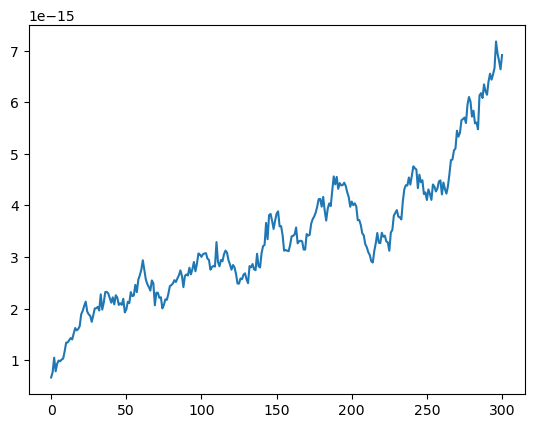

In [8]:
violation_zero = [ np.linalg.norm(x[0][3,:3]) for x in xs_unconstr_euc]

R_unconstr_euc = [ x[0][:3,:3] for x in xs_unconstr_euc ]
violation_orth = [ np.linalg.norm(R.T @ R - np.identity(3)) for R in R_unconstr_euc]

plt.figure()
plt.plot(violation_orth)
# plt.yscale('log')
